# Exploration car incidents claimers

---------------------------------

<font size=3.5 ><text><strong>This notebook analyzes claims recorded between 2005 and 2016.<br> 
The final goal is to <font color=blue>clusterize</font> </strong> cities thanks to the road types where these incidents took place.</text></font>
<br><br>

The notebook is composed with :
<ul>
<li>I – <a href="#chapI">Read and explore cleaned data with SQLite</a></li>
<li>II – <a href="#chapII">Feature engineering and analyze</a></li>
<li>III – <a href="#chapIII">  Explore data related to "Age", "luminosity", "periods" and the driver "gender"</a></li>
<li>IV – <a href="#chapIV">Stude deadly car incident per city</a></li>
<li>V – <a href="#chapV">Clusterize cities thanks to their roads</a></li>

</ul>
<br>
<strong>Data analyzed</strong><br>
<br>
We have here 4 tables :
<br><font color='blue'>CARACTERISTIQUES</font> that describes incident context.
<font color='blue'>LIEUX</font> is the incident place description. 
<font color='blue'>VEHICULES</font> is the car specifications. 
<font color='blue'>USAGERS</font> is the person involved data. <br>

In [3]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

#Read CSV files
data_files = os.listdir('clean_data')
for file in data_files:
    print(file)

acc_aggrege_clean.csv
caracteristiques_gps_cleaned.csv
caracteristiques_info_cleaned.csv
lieux_cleaned.csv
usagers_cleaned.csv
vehicules_cleaned.csv


In [2]:
#Instantiate dataframes
caracteristiques_gps_df = pd.read_csv("clean_data/caracteristiques_gps_cleaned.csv")
caracteristiques_info_df = pd.read_csv("clean_data/caracteristiques_info_cleaned.csv", encoding='latin1')
lieux_df = pd.read_csv("clean_data/lieux_cleaned.csv")
usagers_df = pd.read_csv("clean_data/usagers_cleaned.csv")
vehicules_df = pd.read_csv("clean_data/vehicules_cleaned.csv")


C:\Users\Ludovic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## <p id="chapI">I - Read and explore cleaned data with SQLite</p>

---------------

---------------


In [12]:
import sqlite3
from datetime import datetime

print(str(datetime.now()))

#Database sqlite used to ease dta manipulation and analyze
conn = sqlite3.connect("accidents_corporels.db")
cursor = conn.cursor()

#Get "Luminosity" influence on incidents
#We get caracteristiques informations, 
#   informations from "usager" that is the car driver 
#   and we add some boolean features : 
#         - "Mortel" 1 if there at least 1 person dead or 0 if not
#         - "Obsm" 1 if there are any mobile thing chocked or 0 if not
#         - "Obsf" 1 if there are any not mobile thing chocked or 0 if not
cursor.execute("drop table if exists caract_agg;")
qry = '''create table caract_agg (Num_acc, surf, atm, lum, dep, com, catr, Mortel, an, mois, jour, heure, An_nais, Sexe, trajet)'''
cursor.execute(qry)

#Create indexes to tune SQL queries 
cursor.execute("create index  if not exists usagers_cleaned_idx on usagers_cleaned(Num_Acc)")
cursor.execute("create index  if not exists caracteristiques_info_cleaned_idx on caracteristiques_info_cleaned(Num_Acc)")
cursor.execute("create index  if not exists lieux_cleaned_idx on lieux_cleaned(Num_acc)")
cursor.execute("create index  if not exists vehicules_cleaned_idx on vehicules_cleaned(Num_acc)")

#Calculate statistics to help the sqlite optimizerto establish good access plan
cursor.execute("ANALYZE;")

#Feed "caracteristiques" table with some more calculated data
qry = '''insert into caract_agg select c.Num_Acc as Num_acc, l.surf, c.atm, c.lum,
cast(c.dep as int), cast(c.com as int),
l.catr,
CASE u.nb_tues
    WHEN 0 THEN 0
    ELSE 1 
    END Mortel,
2*1000+c.an as an,
c.mois as mois,
c.jour,
substr(substr('000'||cast(c.hrmn as VARCHAR),-4,4),1,2) as heure,
cast(cond.An_nais as integer) as An_nais, 
cond.Sexe,
cond.trajet
from caracteristiques_info_cleaned c, 
(select lt.surf,lt.Num_acc,lt.catr from lieux_cleaned lt  ) l,
(select uc.An_nais, uc.sexe, uc.Num_Acc, uc.trajet from usagers_cleaned uc where uc.catu=1 GROUP BY uc.Num_Acc 
HAVING MIN(ROWID) ORDER BY ROWID) cond,
(select count(1) as nb_tues,Num_Acc from usagers_cleaned where grav=2 group by Num_Acc 
union 
select 0 as nb_tues,c.Num_Acc from usagers_cleaned c 
                            where c.grav<>2 and c.Num_Acc not in (select distinct t.Num_Acc 
                                                                    from usagers_cleaned t 
                                                                    where t.grav=2 ) 
group by Num_Acc) u
where u.Num_Acc = c.Num_Acc
and l.Num_Acc = c.Num_Acc
and cond.Num_Acc = c.Num_acc
'''
cursor.execute(qry)
cursor.execute("COMMIT;")

acc_aggrege_df = pd.read_sql('''select Num_acc, surf, atm, lum, dep, com, catr, Mortel, an, mois, 
                                jour, heure, An_nais, Sexe, trajet
                                from caract_agg''', conn)
acc_aggrege_df.describe()

#Prepare dataframe that count "véhicules" involved 
nb_vehicule_df = pd.read_sql('''Select count(1) as nb_vehicule,v.Num_Acc as Num_acc from vehicules_cleaned v 
group by v.Num_Acc''', conn)

#Prepare dataframe mobile obstacle chocked
obsm_df = pd.read_sql('''
select A.Num_acc ,  case when B.nb_obsm is null then 0 else B.nb_obsm end as Obsm
from (select v.Num_acc as Num_acc, v.obsm 
from vehicules_cleaned v group by v.Num_acc HAVING MIN(ROWID) ORDER BY ROWID) A 
LEFT OUTER JOIN (select v.Num_acc as Num_acc, count(1) as nb_obsm
from vehicules_cleaned v 
where v.obsm in (1,2,4)
group by v.Num_acc) B
on B.Num_acc = A.Num_acc''', conn)

#Prepare dataframe that count fix obstacles chocked
obsf_df = pd.read_sql('''select A.Num_acc,  case when B.nb_obsf is null then 0 else B.nb_obsf end as Obsf
from (select v.Num_acc from vehicules_cleaned v group by v.Num_acc having min(rowid) order by rowid ) A
LEFT OUTER JOIN
(
select v.Num_acc, count(1) as nb_obsf
from vehicules_cleaned v 
where v.obs in (1,2,3,4,5,6,7,8,9,10,11,12,13)
group by v.Num_acc
) B
on A.Num_acc = B.Num_acc''', conn)


#Trajet_cat : The drive reasons 
map_trajet = {
0 : "Trajet quotidien", #daily drive
1 : "Trajet quotidien", 
2 : "Trajet quotidien",
3 : "Trajet domestique", #domestic drive
4 : "Trajet Pro", #Professional drive
5 :  "Trajet domestique" ,
9 : "Autre" }
acc_aggrege_df["Trajet_cat"] = acc_aggrege_df["trajet"].map(map_trajet)

print(str(datetime.now()))
acc_aggrege_df.head()
    


2017-11-30 20:01:22.819149
2017-11-30 20:03:09.257009


,Num_acc,surf,atm,lum,dep,com,catr,Mortel,an,mois,jour,heure,An_nais,Sexe,trajet,Trajet_cat
0,2.005000e+11,1.0,1.0,3.0,590,11,3.0,0,2005.0,1.0,12.0,19,1976,1,1.0,Trajet quotidien
1,2.005000e+11,1.0,1.0,1.0,590,51,2.0,0,2005.0,1.0,21.0,16,1955,1,5.0,Trajet domestique
2,2.005000e+11,2.0,2.0,3.0,590,51,2.0,0,2005.0,1.0,21.0,18,1983,1,1.0,Trajet quotidien
3,2.005000e+11,1.0,1.0,1.0,590,82,3.0,0,2005.0,1.0,4.0,16,1920,1,5.0,Trajet domestique
4,2.005000e+11,2.0,3.0,3.0,590,478,3.0,0,2005.0,1.0,10.0,19,1949,1,5.0,Trajet domestique


In [13]:
acc_aggrege_df.describe()

,Num_acc,surf,atm,lum,dep,com,catr,Mortel,an,mois,jour,An_nais,Sexe,trajet
count,8.278120e+05,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000
mean,2.010008e+11,1.258487,1.548714,1.907758,563.675646,186.831082,3.410687,0.055998,2010.007341,6.679943,15.597654,1971.723960,1.256396,3.489284
std,3.457111e+08,0.956541,1.589565,1.513857,291.258169,171.941545,1.207681,0.229918,3.457161,3.387457,8.750201,16.594062,0.436643,2.578268
min,2.005000e+11,0.000000,1.000000,0.000000,10.000000,0.000000,1.000000,0.000000,2005.000000,1.000000,1.000000,1898.000000,1.000000,0.000000
25%,2.007000e+11,1.000000,1.000000,1.000000,310.000000,55.000000,3.000000,0.000000,2007.000000,4.000000,8.000000,1961.000000,1.000000,1.000000
50%,2.010000e+11,1.000000,1.000000,1.000000,620.000000,118.000000,4.000000,0.000000,2010.000000,7.000000,15.000000,1975.000000,1.000000,4.000000
75%,2.013000e+11,1.000000,1.000000,3.000000,780.000000,278.000000,4.000000,0.000000,2013.000000,10.000000,23.000000,1985.000000,2.000000,5.000000
max,2.016001e+11,9.000000,9.000000,5.000000,9733.000000,987.000000,9.000000,1.000000,2016.000000,12.000000,31.000000,2015.000000,2.000000,9.000000


In [14]:
#Merge DataFrames counting the "vehicule" number involved with the main DataFrame
result = acc_aggrege_df.join( nb_vehicule_df.set_index('Num_acc'), on='Num_acc')

#Join the main DataFrame with mobile obstacle one and then with the fix ones 
result2 = result.join(obsm_df.set_index("Num_acc"), on = 'Num_acc')
result3 = result2.join(obsf_df.set_index("Num_acc"), on = 'Num_acc')

#Update our aggregated DataFrame
acc_aggrege_df = result3.copy() 

## <p id="chapII">II - Feature engineering and analyze</p>

---------------

---------------


In [15]:
#Week_day :   
acc_aggrege_df['jour_dt'] =  pd.to_datetime((acc_aggrege_df.an*10000+acc_aggrege_df.mois*100+acc_aggrege_df.jour).apply(str),format='%Y%m%d')
days = {"Monday":0,"Tuesday":0,"Wednesday":0,"Thursday":0,"Friday":0,"Saturday":1,"Sunday":1}
acc_aggrege_df["Week_end"] = acc_aggrege_df['jour_dt'].dt.weekday_name.apply(lambda x: days[x])
 

In [16]:
acc_aggrege_df.describe()

,Num_acc,surf,atm,lum,dep,com,catr,Mortel,an,mois,jour,An_nais,Sexe,trajet,nb_vehicule,Obsm,Obsf,Week_end
count,8.278120e+05,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000,827812.000000
mean,2.010008e+11,1.258487,1.548714,1.907758,563.675646,186.831082,3.410687,0.055998,2010.007341,6.679943,15.597654,1971.723960,1.256396,3.489284,1.716738,1.312387,0.191924,0.255336
std,3.457111e+08,0.956541,1.589565,1.513857,291.258169,171.941545,1.207681,0.229918,3.457161,3.387457,8.750201,16.594062,0.436643,2.578268,0.671410,0.929475,0.413689,0.436050
min,2.005000e+11,0.000000,1.000000,0.000000,10.000000,0.000000,1.000000,0.000000,2005.000000,1.000000,1.000000,1898.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.007000e+11,1.000000,1.000000,1.000000,310.000000,55.000000,3.000000,0.000000,2007.000000,4.000000,8.000000,1961.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,2.010000e+11,1.000000,1.000000,1.000000,620.000000,118.000000,4.000000,0.000000,2010.000000,7.000000,15.000000,1975.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
75%,2.013000e+11,1.000000,1.000000,3.000000,780.000000,278.000000,4.000000,0.000000,2013.000000,10.000000,23.000000,1985.000000,2.000000,5.000000,2.000000,2.000000,0.000000,1.000000
max,2.016001e+11,9.000000,9.000000,5.000000,9733.000000,987.000000,9.000000,1.000000,2016.000000,12.000000,31.000000,2015.000000,2.000000,9.000000,56.000000,48.000000,13.000000,1.000000


In [56]:
#Concat variables "Département" and "Commune" to have unique city identifier
acc_aggrege_df[['dep','com']]
acc_aggrege_df["COG"] = acc_aggrege_df['dep'].astype(str)+acc_aggrege_df['com'].astype(str).str.pad(3, side='left', fillchar='0')

In [58]:
#Create variable "Age" and then categorize 
acc_aggrege_df["Age"] = acc_aggrege_df["an"] - acc_aggrege_df["An_nais"]

#Create a category "Classes_age" 
list_class_values = [0,18,30,50,65,110]
labels_age = ["Mineur", "Jeune Adulte", "Adulte", "Quinca", "Retraité"]
acc_aggrege_df["Classes_age"] = pd.cut(acc_aggrege_df["Age"], list_class_values, labels=labels_age)
acc_aggrege_df["Classes_age"] = acc_aggrege_df["Classes_age"].fillna("Mineur")

#Create "lum" labels
lum_map = {
    0.0 : "Plein jour",
    1.0 : "Plein jour",
    2.0 : "Crépuscule ou aube",
    3.0 : "Nuit sans éclairage public",
    4.0 : "Nuit avec éclairage public non allumé",
    5.0 : "Nuit avec éclairage public allumé"
}

acc_aggrege_df["Lum_labels"] = acc_aggrege_df["lum"].map(lum_map)



## <p id="chapIII">III - Explore data related to :</p>

---------------

---------------

<ul>
<li>driver Age</li>
<li>luminosity</li>
<li>period</li>
<li>driver gender</li>
</ul>


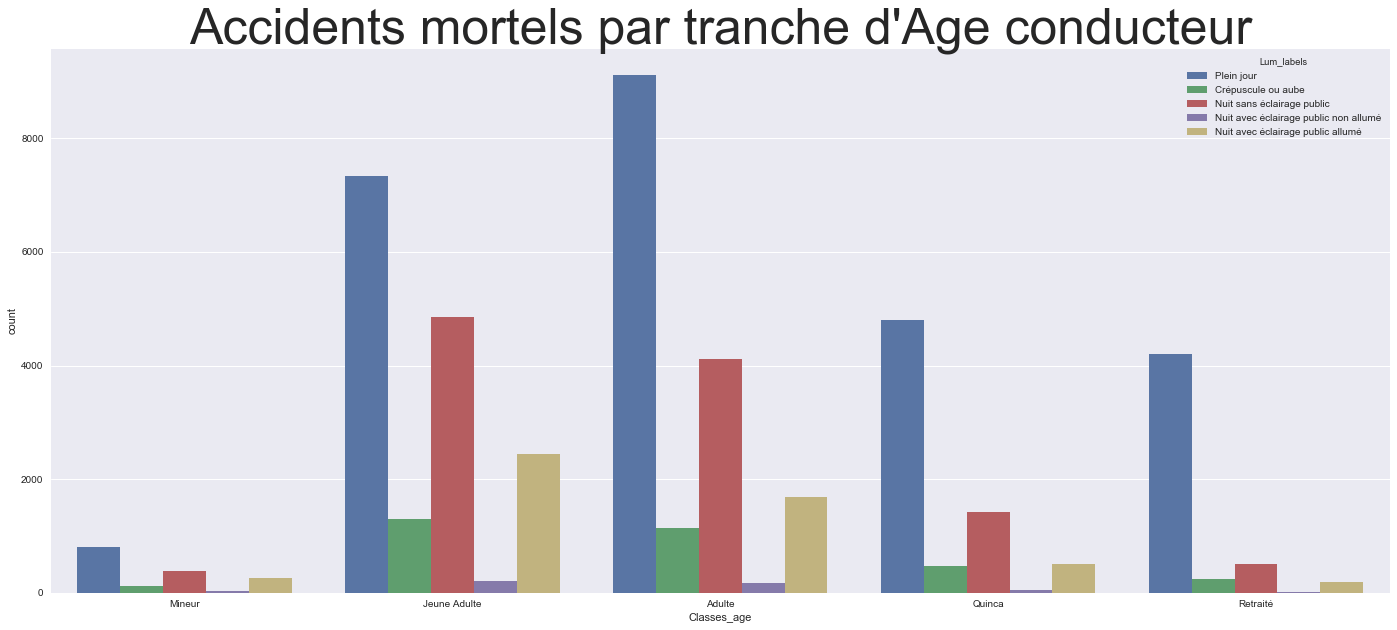

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

hue_orderer = ["Plein jour", "Crépuscule ou aube", "Nuit sans éclairage public", 
               "Nuit avec éclairage public non allumé",  "Nuit avec éclairage public allumé"
    ]

fig = plt.figure(figsize=(24,10))
acc_lum_age = acc_aggrege_df.loc[acc_aggrege_df["Mortel"]==1, ["Classes_age","Lum_labels"]]
sns.countplot(x="Classes_age", data=acc_lum_age, hue="Lum_labels", hue_order= hue_orderer);
plt.title("Accidents mortels par tranche d'Age conducteur",fontsize=50)
plt.show()

Most of the car incidents happens in the middle of the day for the 30-50 years old drivers.
This represents the most important part of the driver on the roads.
So it is directly linked to the incidents characteristics.

<br>
On the other hand, we can observe that during the night, the no enlighted roads are really more deadly than others. 
And we can imagine easily that the more used during the night are the enlighted one.<br>


<strong>What the ratio deadly incidents/incidents number per light type says ?</strong>

In [60]:
print(str(datetime.now()))
#Calculate the incidents number per light type 
qry_nb_mortels_lum = '''select cast(case l.lum when 0 then 1 else l.lum end as int) as lum, count(1) as nb_accidents_mortels 
from usagers_cleaned u, caracteristiques_info_cleaned l
where u.grav=1
and u.Num_acc=l.Num_acc 
group by cast(case l.lum when 0 then 1 else l.lum end as int)  '''
mortels_lum_df = pd.read_sql(qry_nb_mortels_lum, conn)


#Calculate the whole number of incidents per light type
qry_nb_acc_lum = '''select count(1) as nb_accidents, cast(case l.lum when 0 then 1 else l.lum end as int) 
from usagers_cleaned u, caracteristiques_info_cleaned l
where u.Num_acc=l.Num_acc 
group by cast(case l.lum when 0 then 1 else l.lum end as int)  '''
nb_acc_lum_df = pd.read_sql(qry_nb_acc_lum, conn)
print(str(datetime.now()))

#Ratio of the deadly incident number per incident of all types 
ratio_acc_mortel = pd.concat([mortels_lum_df,nb_acc_lum_df["nb_accidents"]], axis=1)
ratio_acc_mortel["ratio_mortel"] = ratio_acc_mortel["nb_accidents_mortels"]/ratio_acc_mortel["nb_accidents"]  


#Labelize lights
ratio_acc_mortel["Lum_labels"] = ratio_acc_mortel["lum"].map(lum_map)

2017-11-30 22:25:25.959432
2017-11-30 22:25:45.344014


In [61]:
ratio_acc_mortel[["Lum_labels","nb_accidents","ratio_mortel"]]
ratio_acc_mortel

,lum,nb_accidents_mortels,nb_accidents,ratio_mortel,Lum_labels
0,1,548485,1296775,0.422961,Plein jour
1,2,42066,107310,0.392004,Crépuscule ou aube
2,3,48183,150891,0.319323,Nuit sans éclairage public
3,4,5763,15095,0.381782,Nuit avec éclairage public non allumé
4,5,120375,305930,0.393472,Nuit avec éclairage public allumé


We observe here that the dead rate for the night incidents where here is no lights for the road is the weakest<br>
despite of thisit is the second context the more deadly for young adults and adults.

We have here a <strong> strong sign of the deadly risk linked to the driver ageduring the night without any lights</strong>.
<br><br>
Other things, the deadly rate of the <b>incidents in the middle of the day</b>, so 42%, and its volume presents the <b>way to lower the number of death on the french roads</b>.
<br><br><br>





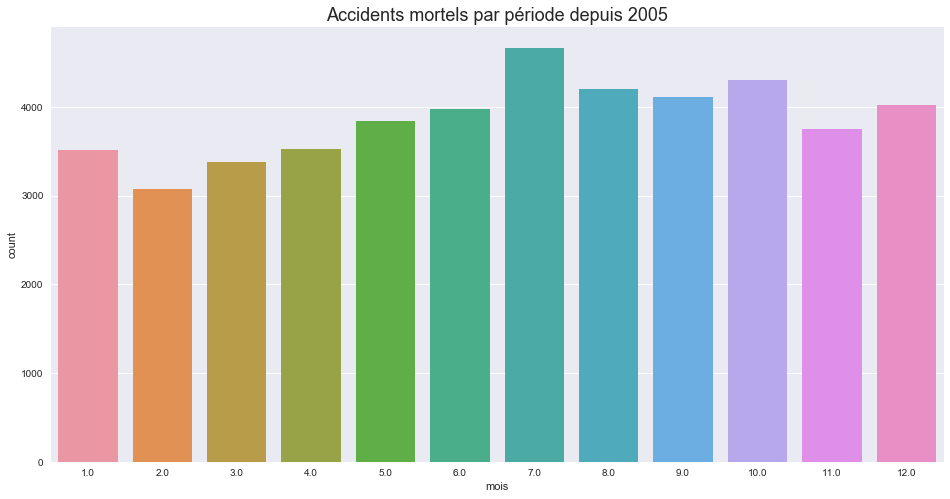

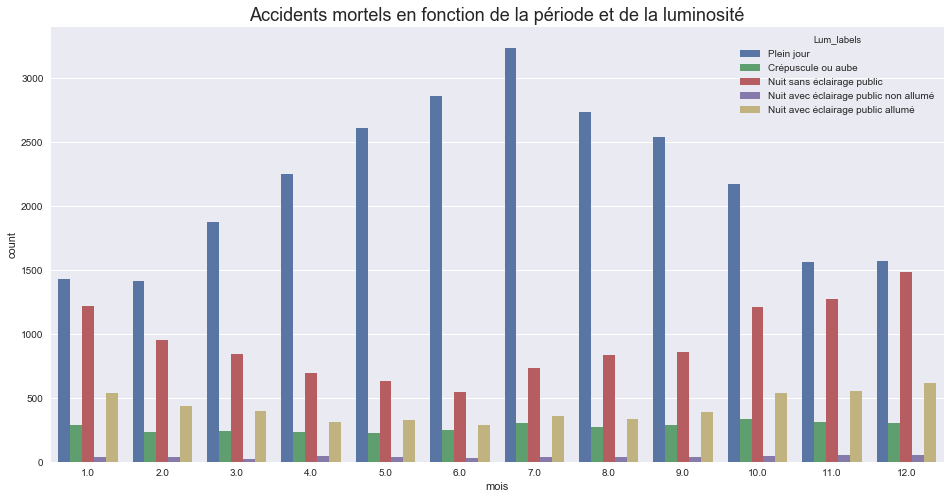

In [62]:
#Monthly death  
fig = plt.figure(figsize=(16,8))
sns.countplot(x="mois", data=acc_aggrege_df.loc[acc_aggrege_df["Mortel"]==1,["mois","Lum_labels"]]);
plt.title("Accidents mortels par période depuis 2005", fontsize=18)
plt.show()

#Print deadly incidents according to the light and the period
fig = plt.figure(figsize=(16,8))
sns.countplot(x="mois", data=acc_aggrege_df.loc[acc_aggrege_df["Mortel"]==1,["mois","Lum_labels"]], hue="Lum_labels", hue_order=hue_orderer);
plt.title("Accidents mortels en fonction de la période et de la luminosité", fontsize=18)
plt.show()



We observe here that the number of incidents during the day and the night correspond to the day light time.

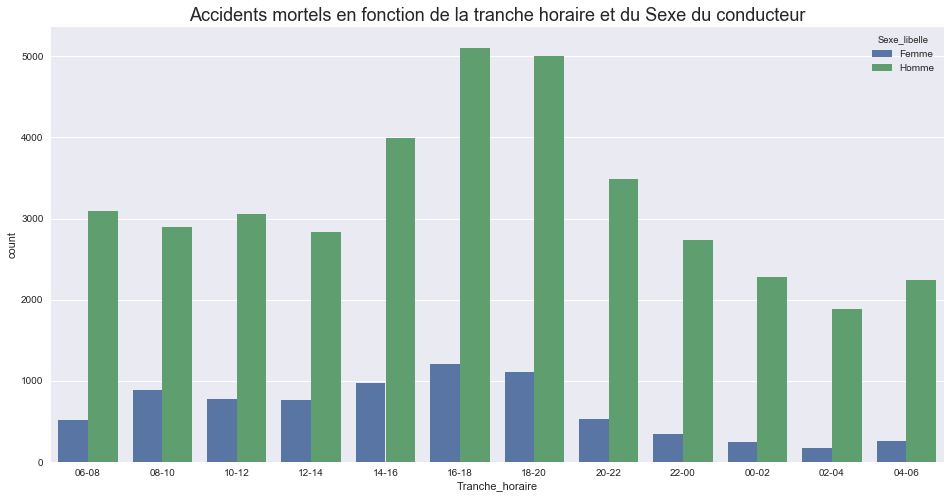

In [63]:
#Stude the hours of the incidents

#Define new categories for the hours of the incidents
map_heure = {
    "00" : "00-02", "01" : "00-02",
    "02" : "02-04", "03" : "02-04",
    "04" : "04-06", "05" : "04-06",
    "06" : "06-08", "07" : "06-08",
    "08" : "08-10", "09" : "08-10",
    "10" : "10-12", "11" : "10-12",
    "12" : "12-14", "13" : "12-14",
    "14" : "14-16", "15" : "14-16",
    "16" : "16-18", "17" : "16-18",
    "18" : "18-20", "19" : "18-20",
    "20" : "20-22", "21" : "20-22",
    "22" : "22-00", "23" : "22-00"    
}

#Gender category
map_Sexe = { 1.0:"Homme", 2.0:"Femme"}

#Apply mappings
acc_aggrege_df.loc[acc_aggrege_df["heure"]=="8\t","heure"] = "08"
acc_aggrege_df["Tranche_horaire"] = acc_aggrege_df["heure"].map(map_heure)
acc_aggrege_df["Sexe_libelle"] = acc_aggrege_df["Sexe"].map(map_Sexe)

#Sum deadly incidents per hours category and per driver gender
deces_par_sexe_horaire_df = acc_aggrege_df.groupby(["Tranche_horaire","Sexe_libelle"])["Mortel"].count().reset_index(name="nb_deces")

ordered = ["06-08","08-10","10-12","12-14","14-16","16-18","18-20","20-22","22-00","00-02","02-04","04-06"]
fig = plt.figure(figsize=(16,8))
sns.countplot(x="Tranche_horaire", order = ordered , data=acc_aggrege_df.loc[acc_aggrege_df["Mortel"]==1,["Sexe_libelle","Tranche_horaire"]], hue="Sexe_libelle")
plt.title("Accidents mortels en fonction de la tranche horaire et du Sexe du conducteur", fontsize=18)
plt.show()


We distinguish death higher for men driver.<br>
We have a higher point between 16 and 20 hours.<br> So at the high traffic time when people come back at home after a day work.<br>

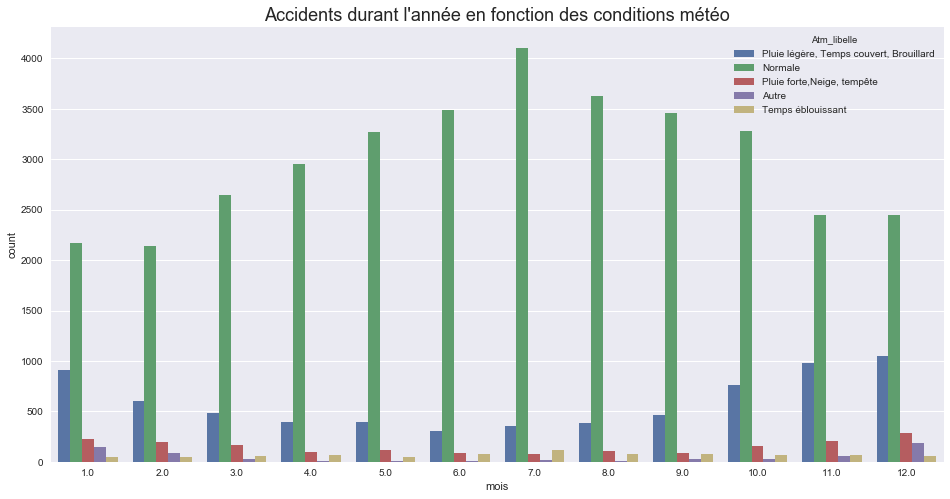

In [64]:
# Categorize weather conditions 
map_atm = {1.0 : "Normale",
2.0 : "Pluie légère, Temps couvert, Brouillard",
3.0 : "Pluie forte,Neige, tempête",
4.0 : "Pluie forte,Neige, tempête",
5.0 : "Pluie légère, Temps couvert, Brouillard",
6.0 : "Pluie forte,Neige, tempête",
7.0 : "Temps éblouissant",
8.0 : "Pluie légère, Temps couvert, Brouillard",
9.0 : "Autre" }
acc_aggrege_df["Atm_libelle"] = acc_aggrege_df["atm"].map(map_atm) 

#Print out deadly incidents and weather conditions for each periods 
fig = plt.figure(figsize=(16,8))
sns.countplot(x="mois", data=acc_aggrege_df.loc[acc_aggrege_df["Mortel"]==1,["mois","Atm_libelle"]], hue="Atm_libelle");
plt.title("Accidents durant l'année en fonction des conditions météo", fontsize=18)
plt.show()


We surprisingly see here that the better weather is the most deadly one !<br>
Is it linked to the fact that during this time we have much more cars on the roads and so more probability to observe incidents.<br>
The best way to conclude something wold be to check if the rate incidents per total cars on the roads is really higher during good weather conditions.<br>

We could also check road types to look after a specific characteristics that ease incidents.<br>

<strong>--> CheckPoint</strong>

In [1]:
#Read data "caracteristiques" enhanced

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import sqlite3
from datetime import datetime
import os
import numpy as np
import pandas as pd

%matplotlib inline

acc_aggrege_df = pd.read_csv("clean_data/acc_aggrege_clean.csv", encoding="latin1")


## <p id="chapIV">IV - Stude deadly car incident per city</p>

---------------

---------------


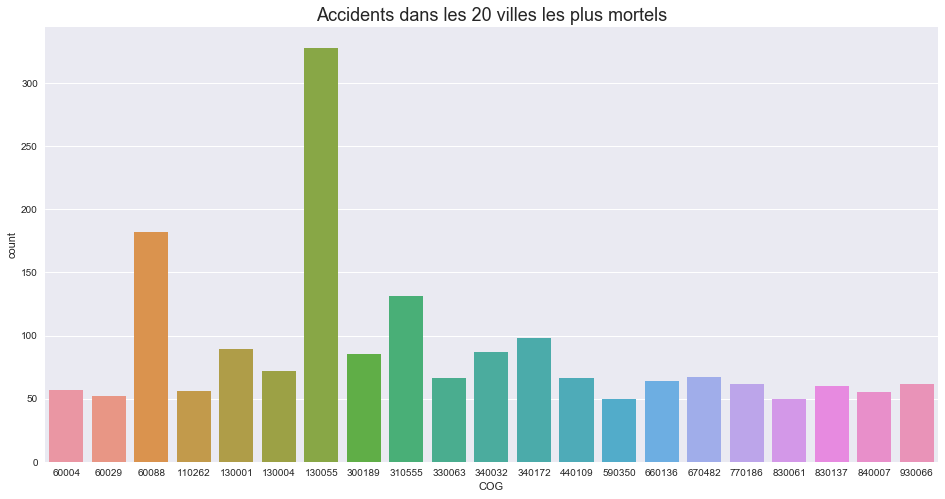

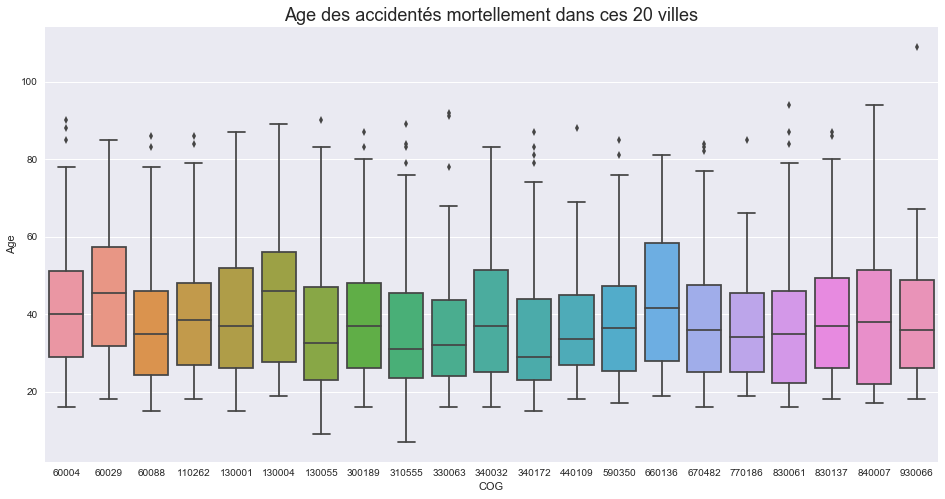

In [2]:
#Filter deadly incidents  
acc_mortels = acc_aggrege_df[acc_aggrege_df["Mortel"]==1].copy()

#Get the top 20 cities with the more important number of incidents
deces_par_ville_df = acc_mortels.groupby("COG")["Mortel"].count().reset_index(name="nb_acc_mortels").sort_values("nb_acc_mortels",ascending=False).reset_index(drop=True)
acc_mortels_top_20_com = acc_mortels.loc[acc_mortels["COG"].isin(deces_par_ville_df.loc[0:20, "COG"]),["COG","Mortel"]]

#Plot histograms of incidents per the selected cities
fig = plt.figure(figsize=(16,8))
sns.countplot(x="COG", data=acc_mortels_top_20_com);
plt.title("Accidents dans les 20 villes les plus mortels", fontsize=18)
plt.show()

#Plot data distribution per Driver Age
acc_mortels_top_20_com_age = acc_mortels.loc[acc_mortels["COG"].isin(deces_par_ville_df.loc[0:20, "COG"]),["COG","Age"]]
fig = plt.figure(figsize=(16,8))
ax = sns.boxplot(x="COG", y="Age", data=acc_mortels_top_20_com_age)
plt.title("Age des accidentés mortellement dans ces 20 villes", fontsize=18)
plt.show()


The city "130055" is the most deadly in France.<br>
The median value of the driver age is around the 30th years old.<br>
The distribution data of the driver Age is right skewed.

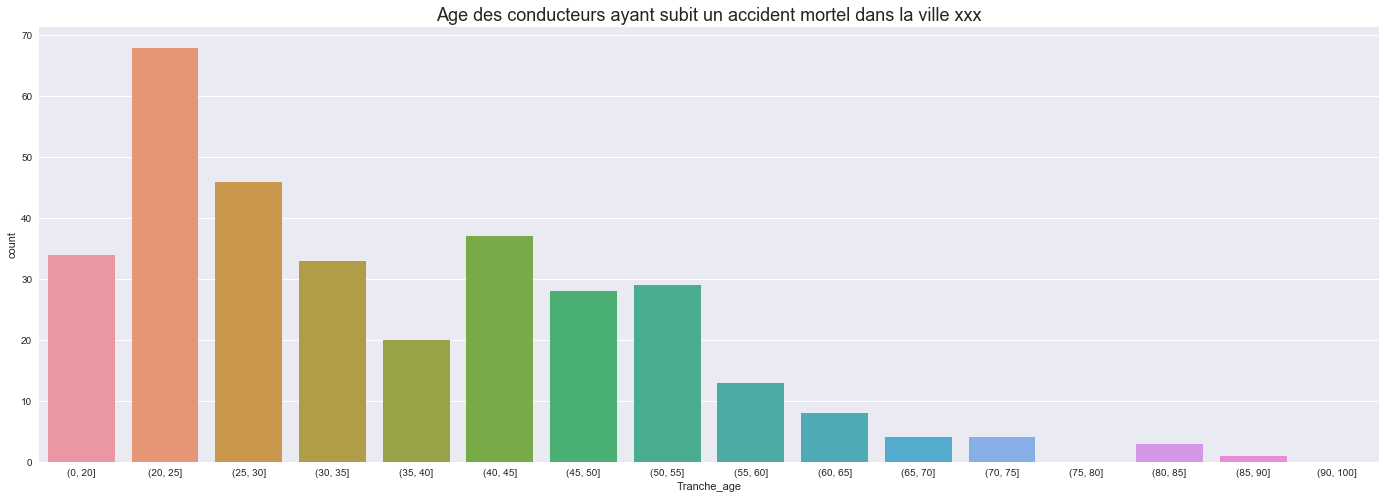

Age median des accidentés : 32.5


In [3]:
#Categorize of driver ages 
acc_mortels_xxx = acc_mortels_top_20_com_age[acc_mortels_top_20_com_age["COG"]==130055].copy()
list_age_values = [0,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100]
acc_mortels_xxx["Tranche_age"] = pd.cut(acc_mortels_xxx["Age"], list_age_values) #, labels=labels_age)

#Data distribution of the driver age having claimed incident into the most deadly city in France
fig = plt.figure(figsize=(24,8))
sns.countplot(x="Tranche_age", data=acc_mortels_xxx);
plt.title("Age des conducteurs ayant subit un accident mortel dans la ville xxx", fontsize=18)
plt.show()
print("Age median des accidentés : {}".format(acc_mortels_xxx["Age"].median()))

We can observe the right skewed data distribution<br>
The mean is so higher than the median that we will take as referencial data.

<strong>Stude now how road type, the Age, and the days interact</strong>

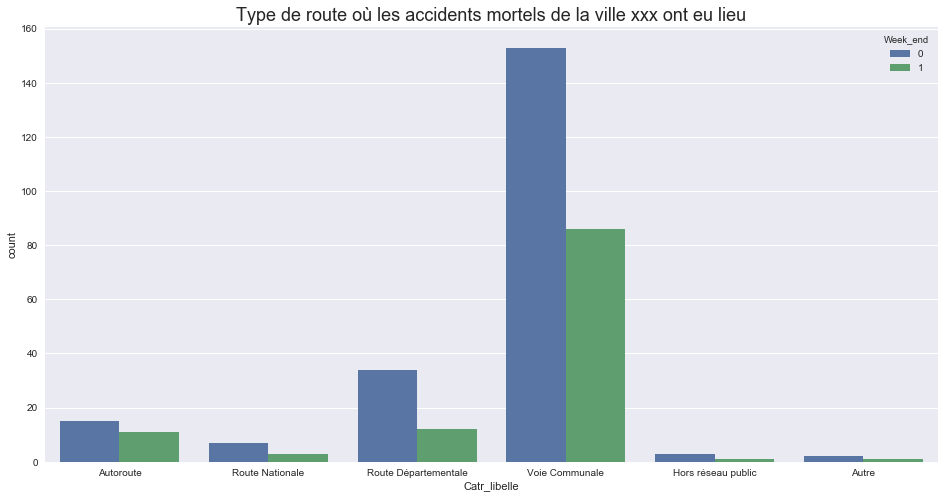

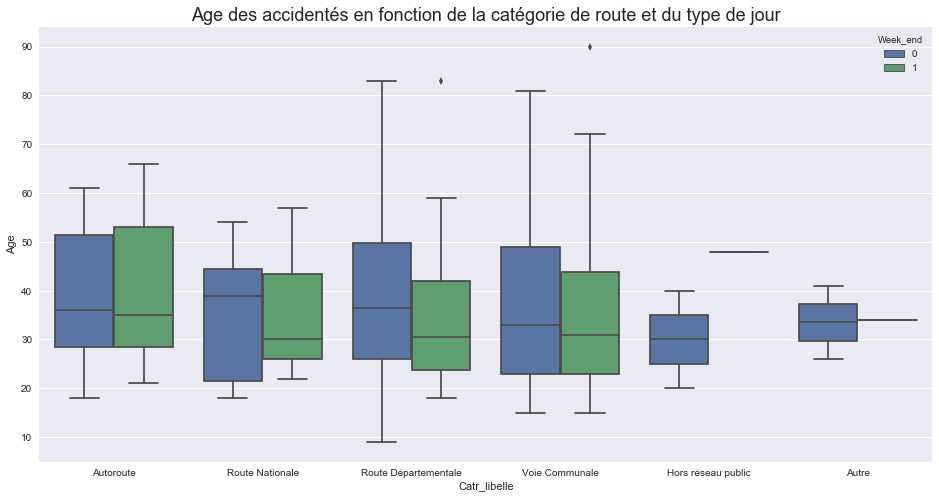

In [4]:
#Create a new variable road category
map_catr = {
    1:"Autoroute",
    2:"Route Nationale",
    3:"Route Départementale",
    4:"Voie Communale",
    5:"Hors réseau public",
    6: 'Autre', #"Parc de stationnement",
    9:"Autre"
}
acc_mortels["Catr_libelle"] = acc_mortels["catr"].map(map_catr) 
acc_mortels_xxx[["Catr_libelle","Week_end"]] = acc_mortels.loc[acc_mortels["COG"]==130055, ["Catr_libelle","Week_end"]]

#Define the category print order 
x_order=["Autoroute", "Route Nationale", "Route Départementale", "Voie Communale", "Hors réseau public", 
         #"Parc de stationnement", 
         "Autre"]

#Road types where incidents took place in the city 130055
fig = plt.figure(figsize=(16,8))
sns.countplot(x="Catr_libelle", data=acc_mortels_xxx, order=x_order, hue="Week_end");
plt.tick_params(labelsize=10)
plt.title("Type de route où les accidents mortels de la ville xxx ont eu lieu", fontsize=18)
plt.show()

#Diaplay incidents depending day type (week-end or not), Driver Age category and road type
fig = plt.figure(figsize=(16,8))
ax = sns.boxplot(x="Catr_libelle", order=x_order , y="Age", hue="Week_end", data=acc_mortels_xxx[["Catr_libelle","Age","Week_end"]])
plt.title("Age des accidentés en fonction de la catégorie de route et du type de jour", fontsize=18)
plt.show()

The incident are the most dangerous during the week on the "Voie communale" ! That are city streets.

## <p id="chapV">V - Clusterize cities thanks to their roads</p>

---------------

---------------

Create city data

In [7]:
#Creation des variables par commune pour les segmenter en fonction des types de routes constituant leur infrastructure
acc_aggrege_df["Catr_libelle"] = acc_aggrege_df["catr"].map(map_catr)

#Pour ne pas alourdir le code créeons une variable une DataFrame Code commune par indicateur nommée simplement "A"
A = acc_aggrege_df.groupby(["COG","Mortel","Catr_libelle"])["Num_acc"].count().reset_index(name="Nb_acc")
A.head()



,COG,Mortel,Catr_libelle,Nb_acc
0,10001,0,Route Départementale,5
1,10001,1,Route Départementale,1
2,10002,0,Route Départementale,1
3,10004,0,Autre,13
4,10004,0,Hors réseau public,1


In [8]:
#Create a pivot on Cities 
B = pd.pivot_table(A, index = "COG", columns=['Mortel','Catr_libelle'], values='Nb_acc' ).reset_index()
B.fillna(0,inplace=True)

#Rename columns with the dead status of the incident as a prefix
cols_0 = ["0_Autoroute","0_Autre","0_Hors_réseau_public","0_Route_Départementale","0_Route_Nationale","0_Voie_Communale"]
B0=B[0].copy()
B0.columns=cols_0

cols_1 = ["1_Autoroute","1_Autre","1_Hors_réseau_public","1_Route_Départementale","1_Route_Nationale","1_Voie_Communale"]
B1=B[1].copy()
B1.columns=cols_1

temp_df = pd.concat((B["COG"],B0 ), axis = 1)
COG_info_df = pd.concat((temp_df,B1 ), axis = 1)




Reduce dimensions and clusterize

In [9]:
#Use Principal Component Analysis 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#Select columns to clusterize
columns_selected = ['0_Autoroute', '0_Autre','0_Hors_réseau_public','0_Route_Départementale','0_Route_Nationale','0_Voie_Communale', 
                   '1_Autoroute', '1_Autre','1_Hors_réseau_public','1_Route_Départementale','1_Route_Nationale','1_Voie_Communale']
data = scale(COG_info_df[columns_selected])
X = data.copy()

#Reduce to 2 components to display data on a 2D graph
pca = PCA(n_components=2)

reduced_data = pca.fit_transform(X)


How many clusters to get stable inertia ?

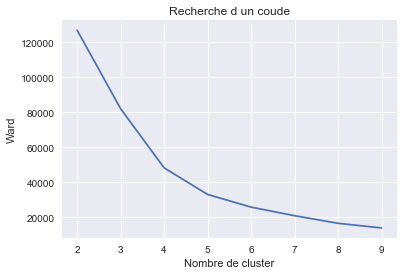

In [10]:
#Look for cluster numbers
from sklearn.cluster import KMeans
ward = []

#Search between 2 and 10 clusters wich one is the more stable set
for i in range(2, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(reduced_data)
    ward.append(kmeans.inertia_)
    
#Plot the inertia curve
plt.plot(range(2, 10), ward)
plt.title('Recherche d un coude')
plt.xlabel('Nombre de cluster')
plt.ylabel('Ward') 
plt.show()

<strong>Display segmentation</strong>

C:\Users\Ludovic\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Ludovic\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Ludovic\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


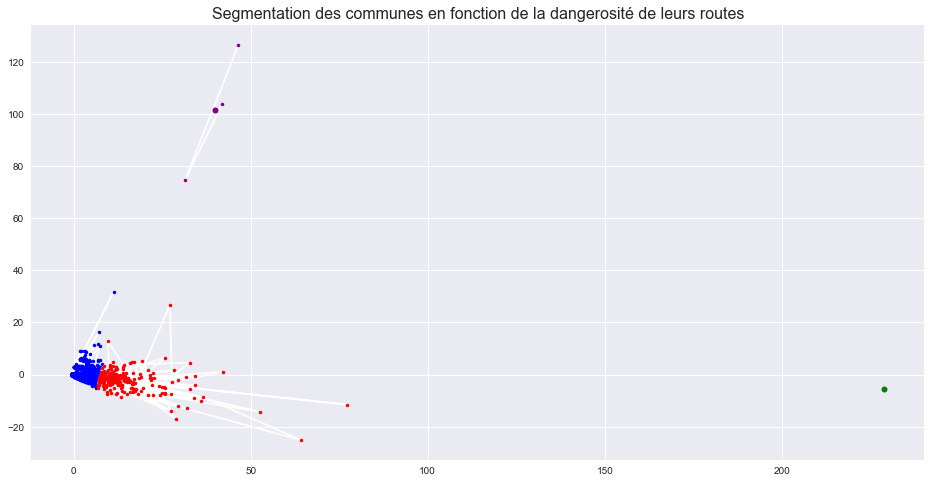

In [11]:
#We will use 4 clusters, because an elbow appears for this value
n_clusters = 4
k_means = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
k_means.fit(reduced_data)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

##############################################################################
# Segment visualization
colors = ['blue', 'red', 'green', 'purple']
fig = plt.figure(figsize=(16,8))
plt.hold(True)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(reduced_data[my_members, 0], reduced_data[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)

plt.title('Segmentation des communes en fonction de la dangerosité de leurs routes', fontsize=16)    
plt.grid(True)
plt.show()

We can now stude which cities are presents into these 4 clusters and build insurance offer linked to these clusters.<br>

Display now clustering in 3D

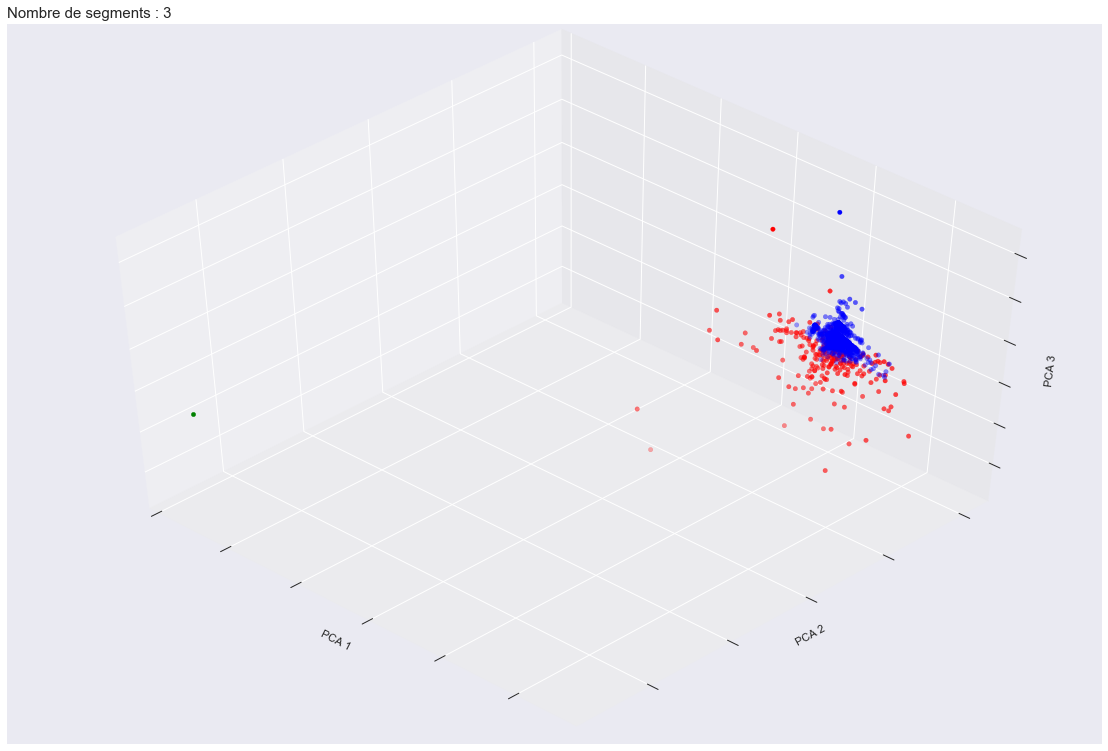

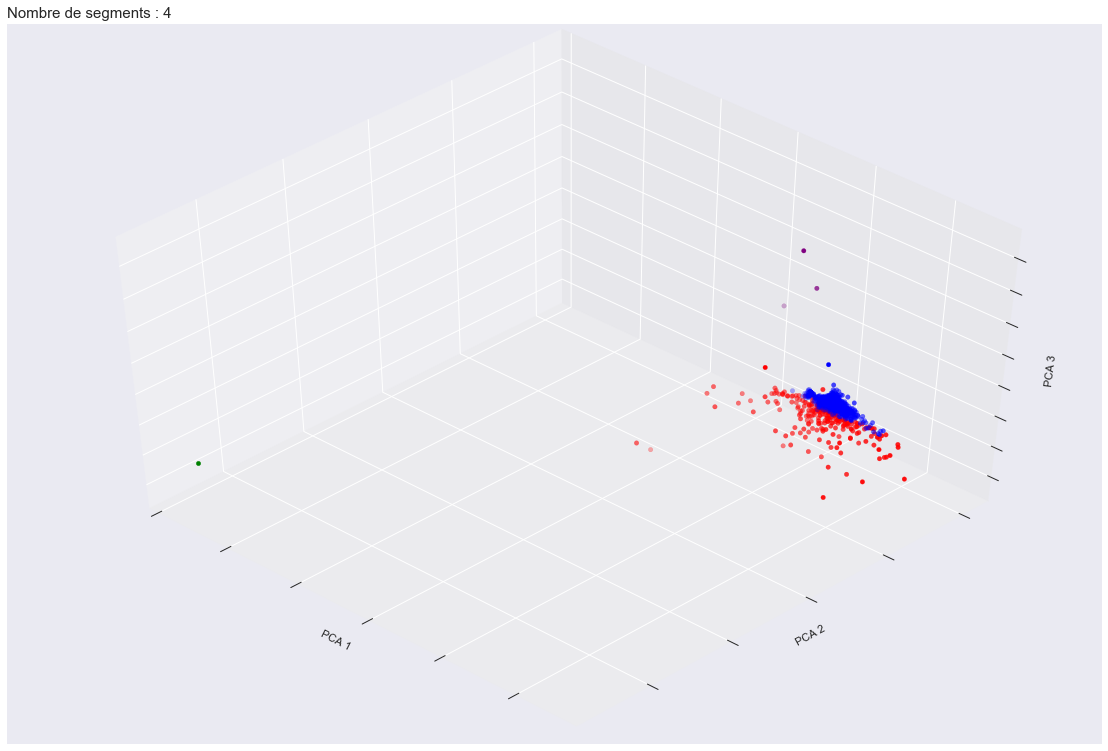

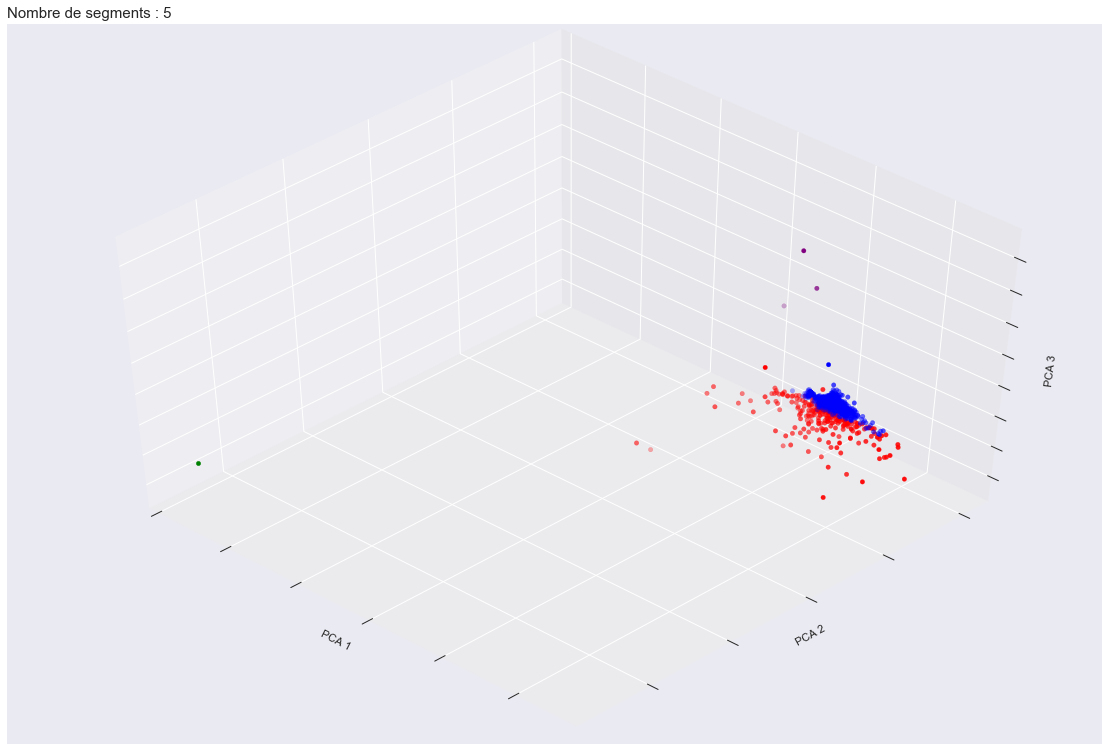

In [12]:
#Reduce to 3 dimensions 

#Select variables
columns_selected = ['0_Autoroute', '0_Autre','0_Hors_réseau_public','0_Route_Départementale','0_Route_Nationale','0_Voie_Communale', 
                   '1_Autoroute', '1_Autre','1_Hors_réseau_public','1_Route_Départementale','1_Route_Nationale','1_Voie_Communale']
data = scale(COG_info_df[columns_selected])
X = data.copy()

#3 components for a 3D display
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X)


##############################################################################
# Set colors
colors = ['blue', 'red', 'green', 'purple']

#Plot 3 D
from mpl_toolkits.mplot3d import Axes3D

#Dictionary of clusterizations  
estimators = {'3': KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0),
              '4': KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0),
              '5': KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0) }

#Display
fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(16, 10))
    plt.clf()
    
    #Set the 3D graph
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

    plt.cla()
    
    est.fit(reduced_data)
    labels = est.labels_

    #For each cluster set a specific color
    for k, col in zip(range(int(name)), colors):
        my_members = k_means_labels == k
        ax.scatter(reduced_data[my_members, 2], reduced_data[my_members, 0], reduced_data[my_members, 1], c=col)

    #Set labels
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_zlabel('PCA 3')
    ax.set_title("Nombre de segments : {}".format(name), loc='left', fontsize=15)
    fignum = fignum + 1
    
    
    

In [19]:
for k, col in zip(range(int(name)), colors):
        my_members = k_means_labels == k
        if col == "green":
            print("Segment de couleur verte :")
            print(COG_info_df.loc[my_members, "COG"])
        if col == "purple":
            print("Segment de couleur violette :")
            print(COG_info_df.loc[my_members, "COG"])

        

Segment de couleur verte :
3424    130055
Name: COG, dtype: int64
Segment de couleur violette :
8871     290019
17679    560121
24280    720181
Name: COG, dtype: int64
